In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.291256  0.402844 -1.005044 -0.418129  0.193278 -0.113837  0.045247   
  1   0.887726  0.505896  0.226920  0.478918  0.836645 -0.478677 -0.386397   
  2   0.220507 -0.234206  0.199493 -1.005956 -0.157991 -0.895344 -0.138398   
  3   0.735838  0.036370 -0.217193 -0.451914 -0.037748  0.121303  0.010430   
  4  -0.482293 -0.357185 -0.956755 -0.261179 -0.338193  0.305462 -0.375362   
  5   0.091202  0.606327 -0.120974  0.956123  0.691855  0.677939 -0.075812   
  6   0.724150  0.181798 -0.138559 -0.690059 -0.803921 -0.317970 -0.036262   
  7   0.293966 -0.258273 -0.581451 -0.450568  1.188171  1.210667  1.060145   
  8   0.338816 -0.446529 -0.252755 -0.880386 -0.900276  0.330306  0.714602   
  9   0.525259 -0.647303  0.553007 -0.106077  0.605675  0.675520  0.114291   
  10  0.414899  0.124944 -0.777572 -0.505814 -0.189426  0.531188  0.888768   
  11  0.104023 -0.687947 -0.756374 -1.429215 -0.256446 -0.400034  0.622345   
  12  1.092319  0.400365  0.041636 -0.647161  0.091450 -0.190442  1.385617   
  13 -0.508315  0.606209  0.154609 -0.861441 -0.533736 -0.422921  0.054550   
  14  0.394456 -0.693109  0.025296  0.264288 -0.325584 -0.977303 -0.229072   
  15 -0.390571  0.980234  0.288904 -0.100631  0.777882  0.484797  0.532319   
  16 -0.872705 -0.204787 -0.398566 -0.241954  0.355357 -0.625931  0.091469   
  17 -1.451183 -0.582768 -0.468071 -0.421006 -0.360820  0.587584  0.399781   
  18  0.016631 -0.113245 -1.431263 -0.623046  0.946644  0.842364 -0.228769   
  19 -0.219052 -1.286765  0.140173 -1.170257  0.509331  0.473208  0.303451   
  20  0.552386 -0.797410 -0.071149  0.276221 -0.042305  0.284690  0.354232   
  21  0.148953  0.876240 -0.269767 -0.476745 -0.026540 -0.544227  0.356846   
  22  0.535147  0.174941 -0.436657 -0.373202  0.145737  1.026323  0.851440   
  23 -0.135438 -0.689009 -0.646696  0.524214 -0.912015 -0.523690 -0.395858   
  24 -0.467875 -0.386352  0.323367 -0.604277 -0.004282 -0.200821 -0.620902   
1 0   0.062591 -0.805726  0.097095 -0.225259  1.525464  1.924960  0.185391   
  1   0.063636 -0.443898  0.174563  0.066326  1.031283  1.636630  0.398804   
  2   0.493241 -1.076359  0.595855  0.214869  0.114627  0.131310  0.433765   
  3  -0.564689 -0.248397 -0.383029  0.420318  0.271450  0.081069  0.425661   
  4   0.277698 -0.589426 -0.727233 -0.043483  0.489024  0.712909  0.145768   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.059087  0.111615  1.427325  ...  0.335132 -1.020837 -0.397247   
  1   0.100500 -0.089799 -0.760915  ... -0.349061 -0.221620  0.467427   
  2  -0.988744  0.433158  0.482325  ...  0.464694  0.623193 -0.278547   
  3   0.517764 -0.136790 -0.223704  ...  0.015384  0.230409 -0.020376   
  4   0.806046 -0.869313  0.156906  ... -0.396871 -0.134811 -0.275435   
  5   0.336292  1.136488  0.587761  ...  0.048832 -1.156508  0.835602   
  6  -0.183749  0.540529  0.786602  ... -0.384817  0.166243 -0.119274   
  7  -0.030506 -0.721740  0.260987  ...  0.717549 -0.449619  0.530116   
  8   0.022705 -0.267581  0.965865  ... -0.117629 -0.046827 -1.056360   
  9   1.586141 -0.160676 -0.378819  ...  1.181519  0.585632  0.123766   
  10  0.600192  0.618788  0.205529  ...  0.603546 -0.040886 -0.342698   
  11  0.350621  0.811064  0.322335  ...  0.283298  0.693522  0.126534   
  12  0.311730 -0.414929 -0.931031  ... -1.399587 -0.580426 -0.096108   
  13  0.604031 -1.069460 -0.680765  ...  1.095162  0.027332 -0.413354   
  14  0.094027 -0.056286  0.490613  ...  0.399480  0.136083  0.065862   
  15  0.125268  0.389296  0.334254  ...  0.220666 -0.926344 -0.914524   
  16 -0.400182 -0.795495 -0.551428  ... -0.410529 -0.050981  0.726231   
  17  0.813687  0.105073 -0.062077  ... -0.257481 -0.923979 -0.429707   
  18 -0.826758 -0.242510  0.215230  ... -0.662297 -0.270969  0.351071   
  19  0.634558  0.756901  0.002623  ...  0.109408 -0.643231 -1.057898   
  20 -0.282829 -0.406958  0.074277  ...  0.246842 -0.305897 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  0.993075  0.044782  22.175908  5.867897e-109  0.905305  1.080846


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



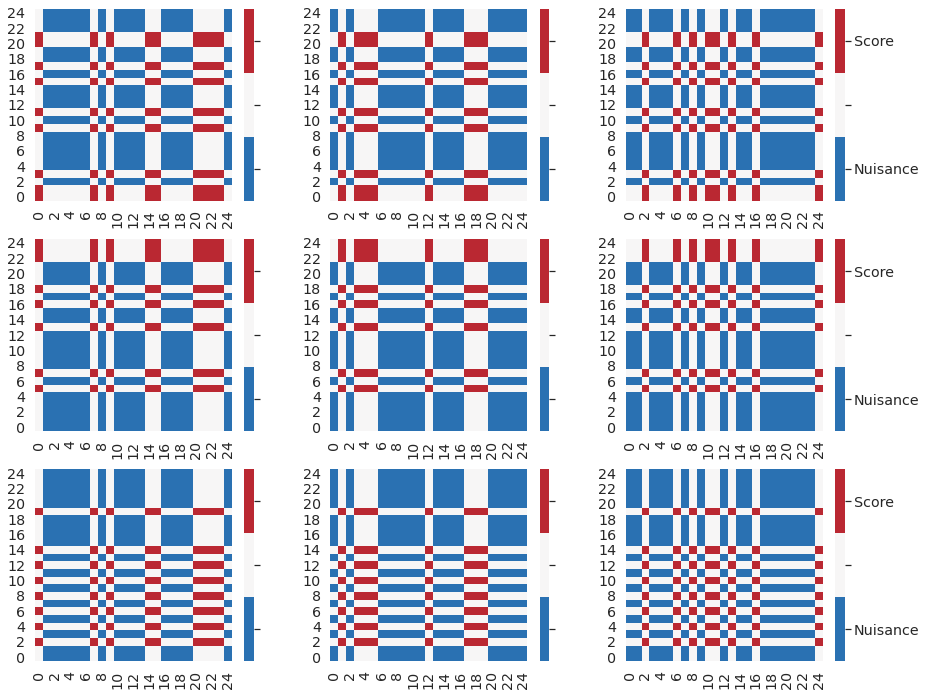

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



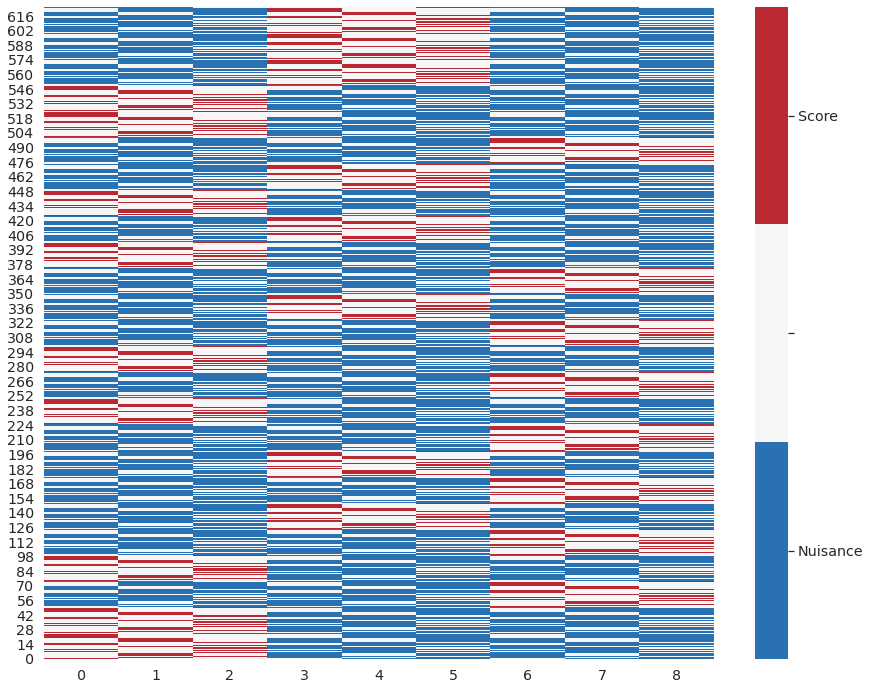

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])